### import modules and dataset

In [56]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stud-math/stud_math.csv


In [57]:
df = pd.read_csv('/kaggle/input/stud-math/stud_math.csv')

### custom functions

In [58]:
# Function to calculate missing values by column
def info_tab(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        table = pd.concat([mis_val, mis_val_percent, df.dtypes, df.min(), df.max(), df.mean(), df.nunique()], axis=1)
        table_columns = table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'Variables type', 3: 'Min value',
                  4: 'Max value', 5: 'Mean value', 6: 'Number of unique values'})
        table_columns = table_columns[table_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(table_columns.shape[0]) +
              " columns that have missing values.")
        return table_columns

In [59]:
#Function to set distribution plot and show IQR
def get_iqr(col):
    median = df[col].median()
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25, perc75 = df[col].quantile(0.25), df[col].quantile(0.75)
    print('25th percentile :', perc25)
    print('75th percentile :', perc75)
    print('IQR: ', IQR)
    print('Outliers bounds: [{}, {}]'.format(perc25 - 1.5*IQR, perc75 + 1.5*IQR))
    sns.distplot(df[col].loc[df[col].between(perc25 - 1.5 * IQR, perc75 + 1.5 * IQR)])

In [60]:
#Function to get boxplots
def get_boxplot(col):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=col, y='score', data=df.loc[df.loc[:, col].isin(df.loc[:, col].value_counts().index[:10])], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + col)
    plt.show()

In [61]:
#Function to get boxplot and distribution plot
def get_plot(col, bins=20):
    fig, ax = plt.subplots(1,2,figsize=(20,5))
    sns.boxplot(df[col], ax=ax[0])
    sns.distplot(df[col], hist=True, bins=bins, ax=ax[1])

In [62]:
#Function to change NA (categorical variables) to median
def return_median(col):
    df[col] = df[col].fillna(df[col].median())
    return df

In [63]:
#Function to change NA (binary variables) to mode
def return_mode(col):
    df[col] = df[col].fillna(df[col].mode()[0])
    return df

In [64]:
#Function to build a boxplot
def get_boxplot(col):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=col, y='score', data=df.loc[df.loc[:, col].isin(df.loc[:, col].value_counts().index[:10])], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + col)
    plt.show()

In [65]:
#T test
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'].dropna(), 
                     df.loc[df.loc[:, column] == comb[1], 'score'].dropna()).pvalue <= 0.05/len(combinations_all):
            print('Statistically significant differences are found for', column)
            break

### EDA

In [66]:
df.sample(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
207,GP,F,16,U,GT3,T,4.0,3.0,teacher,other,...,-6.0,yes,yes,yes,1.0,3.0,2.0,1.0,10.0,65.0
149,GP,M,15,U,LE3,NaN,2.0,1.0,services,other,...,-3.0,NaN,yes,no,4.0,5.0,5.0,5.0,0.0,50.0
187,GP,M,16,U,LE3,T,2.0,1.0,other,other,...,-6.0,yes,yes,yes,4.0,2.0,3.0,5.0,0.0,75.0
97,GP,F,16,U,GT3,T,2.0,1.0,other,other,...,-6.0,yes,no,yes,4.0,3.0,5.0,5.0,2.0,50.0
237,GP,F,16,U,NaN,T,2.0,1.0,other,other,...,-3.0,yes,yes,yes,4.0,5.0,2.0,5.0,20.0,60.0


In [67]:
# 1 school — аббревиатура школы, в которой учится ученик
# 2 sex — пол ученика ('F' - женский, 'M' - мужской)
# 3 age — возраст ученика (от 15 до 22)
# 4 address — тип адреса ученика ('U' - городской, 'R' - за городом)
# 5 famsize — размер семьи('LE3' <= 3, 'GT3' >3)
# 6 Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)
# 7 Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
# 8 Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
# 9 Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
# 10 Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
# 11 reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)
# 12 guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)
# 13 traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)
# 14 studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)
# 15 failures — количество внеучебных неудач (n, если 1<=n<3, иначе 0)
# 16 schoolsup — дополнительная образовательная поддержка (yes или no)
# 17 famsup — семейная образовательная поддержка (yes или no)
# 18 paid — дополнительные платные занятия по математике (yes или no)
# 19 activities — дополнительные внеучебные занятия (yes или no)
# 20 nursery — посещал детский сад (yes или no)
# 21 higher — хочет получить высшее образование (yes или no)
# 22 internet — наличие интернета дома (yes или no)
# 23 romantic — в романтических отношениях (yes или no)
# 24 famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
# 25 freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)
# 26 goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)
# 27 health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
# 28 absences — количество пропущенных занятий
# 29 score — баллы по госэкзамену по математике

**renaming columns**

In [68]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

In [69]:
df.columns = ['school', 'sex', 'age', 'address', 'famsize', 'pstatus', 'medu', 'fedu',
       'mjob', 'fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime_gran', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score']

**checking number of NAN/null and type**

In [70]:
info_tab(df)

Your selected dataframe has 30 columns.
There are 27 columns that have missing values.


,Missing Values,% of Total Values,Variables type,Min value,Max value,Mean value,Number of unique values
pstatus,45,11.4,object,NaN,NaN,NaN,2
paid,40,10.1,object,NaN,NaN,NaN,2
famsup,39,9.9,object,NaN,NaN,NaN,2
fjob,36,9.1,object,NaN,NaN,NaN,5
internet,34,8.6,object,NaN,NaN,NaN,2
romantic,31,7.8,object,NaN,NaN,NaN,2
guardian,31,7.8,object,NaN,NaN,NaN,3
traveltime,28,7.1,float64,1,4,1.4,4
famrel,27,6.8,float64,-1,5,3.9,6
famsize,27,6.8,object,NaN,NaN,NaN,2


1. Most of the columns has NAN.
2. Number of unique values is low.
3. Data errors (fedu = 40, famrel = -1)

#### fixing data errors

In [71]:
df.fedu.value_counts()

2.0     106
3.0      96
4.0      88
1.0      78
0.0       2
40.0      1
Name: fedu, dtype: int64

In [72]:
df.fedu = df.fedu.apply(lambda x: 4 if x == 40 else x)

In [73]:
df.famrel.value_counts()

 4.0    182
 5.0     99
 3.0     62
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

In [74]:
df.famrel = df.famrel.apply(lambda x: 1 if x == -1 else x)

In [75]:
df[df['address'] == 'R']['reason'].value_counts()

course        33
reputation    28
home          11
other         10
Name: reason, dtype: int64

### quantative variables analysis

#### variables: abcenses, age, score
1. filling NA with median
2. looking at distribution
3. deleting outliers (IQR)

### absences

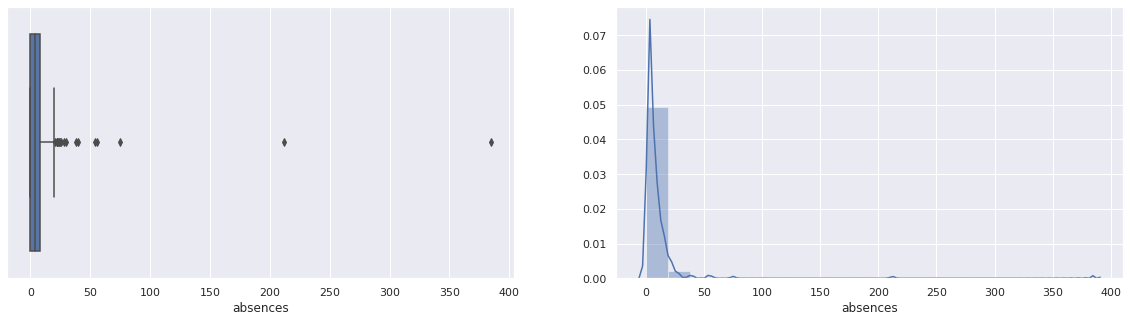

In [76]:
df.absences = df.absences.fillna(df.absences.median())
get_plot('absences')

right skewed distribution, students are likely not to skip lessons

25th percentile : 0.0
75th percentile : 8.0
IQR:  8.0
Outliers bounds: [-12.0, 20.0]


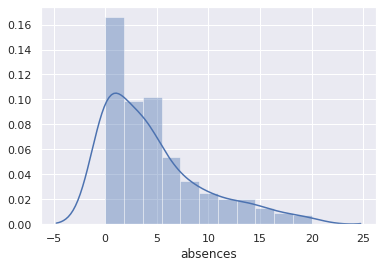

In [77]:
get_iqr('absences')

In [78]:
df = df.loc[df.absences.between(0, 20)]

### age

In [79]:
df.age.unique()

array([18, 17, 15, 16, 19, 22, 20, 21])

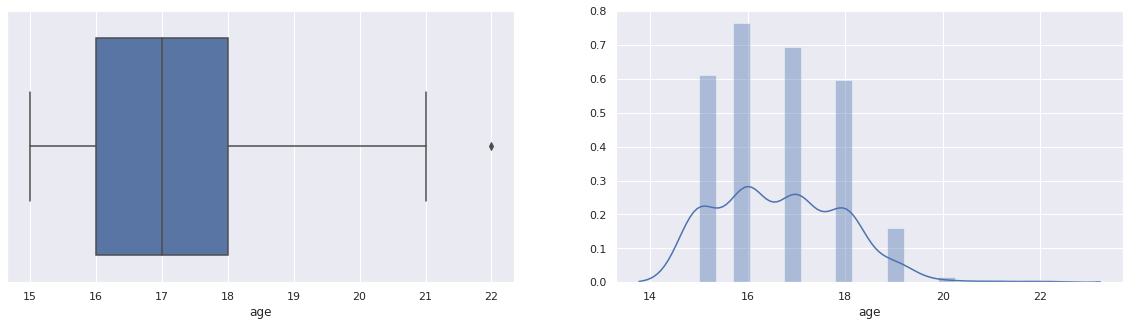

In [80]:
df.age = df.age.fillna(df.age.median())
get_plot('age')

most students are at the age 16-18

25th percentile : 16.0
75th percentile : 18.0
IQR:  2.0
Outliers bounds: [13.0, 21.0]


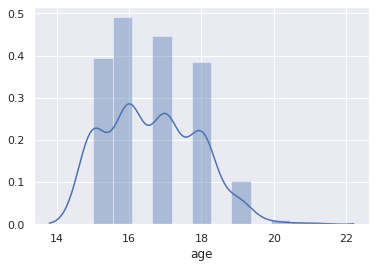

In [81]:
get_iqr('age')

In [82]:
df = df.loc[df.age.between(13, 21)]

### score

In [83]:
df.score.unique()

array([ 30.,  50.,  75.,  55.,  95.,  45.,  60.,  70.,  80.,  25.,  40.,
        85.,  90.,  65., 100.,  35.,   0.,  nan])

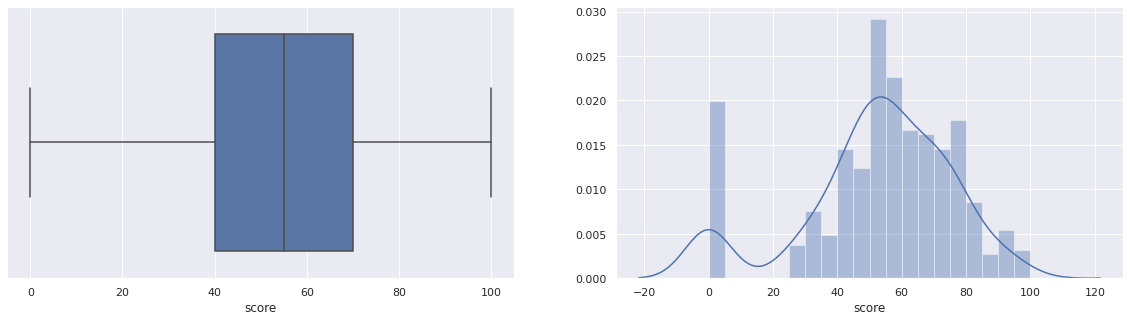

In [84]:
get_plot('score')

'Score' is a target attribute.
0 points may be because of the students absence, so it's better to delete it. There are only 6 NaN, they should be deleted as well. 

In [85]:
df = df[(df.score.notna() & df.score != 0)]

25th percentile : 50.0
75th percentile : 70.0
IQR:  20.0
Outliers bounds: [20.0, 100.0]


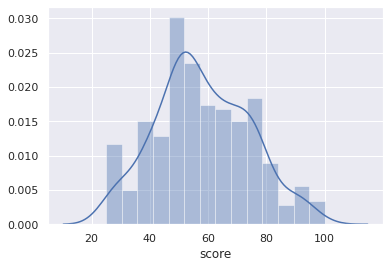

In [86]:
get_iqr('score')

outliers not found

### correlation analysis

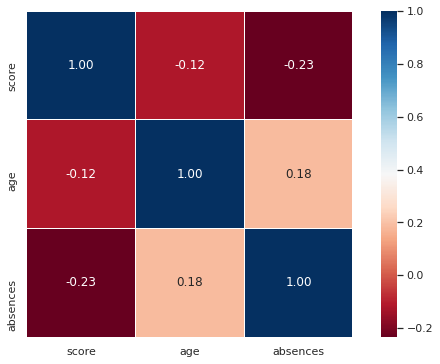

In [87]:
sns.set(font_scale=1)
plt.subplots(figsize=(10, 6))
sns.heatmap(df[['score', 'age', 'absences']].corr(), square=True,
              annot=True, fmt=".2f", linewidths=0.1, cmap="RdBu")

## categorical variables analysis

'studytime, granular' seems to be similar to 'studytime'. let's find out with correlation analysis

In [88]:
df[['studytime_gran', 'studytime']].corr()

,studytime_gran,studytime
studytime_gran,1.0,-1.0
studytime,-1.0,1.0


that was true. let's delete one of the variable ('studytime_gran')

In [89]:
df.drop(['studytime_gran'], axis=1, inplace=True)

Strategy:
1. look at histogram
2. fill NA with median

**traveltime**

In [ ]:
df.traveltime.hist()
return_median('traveltime')

it take 1h to get to school fot most of the students

**famrel**

In [ ]:
df.famrel.hist()
return_median('famrel')

there are few students who has bad relationships with parents

**fedu**

In [ ]:
df.fedu.hist()
return_median('fedu')

In [ ]:
df.medu.hist()
return_median('medu')

mothers (medu) are tend to have higher education than fathers

**failures**

In [ ]:
df.failures.hist()
return_median('failures')

most of the students don't have failures at all

**health**

In [ ]:
df.health.hist()
return_median('health')

**freetime**

In [ ]:
df.freetime.hist()
return_median('freetime')

normal distribution

**goout**

In [ ]:
df.goout.hist()
return_median('goout')

normal distribution as well. maybe this variable connected with 'freetime'?

In [ ]:
df[['goout', 'freetime']].corr()

it's not. will use 2 variables in the model

**studytime**

In [ ]:
df.studytime.hist()
return_median('studytime')

**binary variables**

In [ ]:
binary = ['sex', 'school', 'address', 'famsize', 'pstatus', 'schoolsup', 'famsup', 'paid', 
          'activities', 'nursery', 'higher', 'internet', 'romantic']

filling NA with mode

In [ ]:
for i in binary:
    return_mode(i)

**nominal variables**

In [ ]:
nominal = ['mjob', 'fjob', 'reason', 'guardian']

changing NaN to 'not known'

In [ ]:
for i in nominal:
    df[i] = df[i].fillna('not_known')

**before building a model nominal variables should be changed to dummy (drop_first='True')**

## Boxplots

In [ ]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [ ]:
var_for_boxplot = ['school', 'medu', 'fedu', 'mjob', 'fjob', 'reason', 'guardian','traveltime', 
                   'studytime', 'failures', 'famrel', 'freetime', 'goout', 'health', 'sex', 
                   'address', 'famsize', 'pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 
                   'nursery', 'higher', 'internet','romantic']
for i in var_for_boxplot:
    get_boxplot(i)

## T-test for feature selection

In [ ]:
for i in var_for_boxplot:
    get_stat_dif(i)

these variables are recommended for futher using

## Conclusions

1. dataset had lots of NA
2. NA was filled with median, mode or changed to 'not_known'
3. outliers were deleted using IQR
4. variables to be used: age, absences, medu, fedu, mjob, studytime, failures, health, sex, address, schoolsup
5. binary variables should be encoded with LabelEncoder from sklearn.preprocessing
6. nominal variables should be encoded as dummy variables (drop_first='True')